In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import io
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from IPython.display import Image
import requests
sns.set_style('whitegrid')
%matplotlib inline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,accuracy_score, classification_report,f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, learning_curve, validation_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, auc, roc_auc_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_hist_gradient_boosting

In [158]:
# plot_learning_curve function from official scikit-learn documentation

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="orange",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="blue",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-', color="blue")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-', color="blue")
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def plot_validation_curve(estimator, title, X, y, param_name, param_range, scoring="accuracy", axes=None, ylim=None, cv=10,
                            n_jobs=-1):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        scoring=scoring, n_jobs=n_jobs, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax = plt.subplot()

    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel(scoring + " Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw, )
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="blue", lw=lw)
    plt.legend(loc="best")
    
    return plt

def plot_roc_auc_curve(estimator, x_test, y_test, y_pred, title="Receiver operating characteristic (ROC Curve)"):
    probs = estimator.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='orange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    return plt


# 1. Data Reading and Preprocessing

In [159]:
df = pd.read_excel('default of credit card clients.xls', header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,0


In [160]:
df1 = df.drop('ID', axis=1)

In [161]:
df1.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,1
1,120000,2,2,2,26,-1,2,0,0,0,2,1
2,90000,2,2,2,34,0,0,0,0,0,0,0
3,50000,2,2,1,37,0,0,0,0,0,0,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,0


In [162]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  default payment next month  30000 non-null  int64
dtypes: int64(12)
memory usage: 2.7 MB


In [163]:
fil = (df1.EDUCATION == 5) | (df1.EDUCATION == 6) | (df1.EDUCATION == 0)
df1.loc[fil, 'EDUCATION'] = 4
df1.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [164]:
df1.loc[df1.MARRIAGE == 0, 'MARRIAGE'] = 3
df1.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [165]:
df1 = df1.rename(columns={'PAY_0':'PAY_1'})

In [166]:
df1

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,1
1,120000,2,2,2,26,-1,2,0,0,0,2,1
2,90000,2,2,2,34,0,0,0,0,0,0,0
3,50000,2,2,1,37,0,0,0,0,0,0,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,0,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,0,1
29998,80000,1,3,1,41,1,-1,0,0,0,-1,1


In [167]:
fil = (df1.PAY_1 == -2) | (df1.PAY_1 == -1) | (df1.PAY_1 == 0)
df1.loc[fil, 'PAY_1'] = 0 
fil = (df1.PAY_2 == -2) | (df1.PAY_2 == -1) | (df1.PAY_2 == 0)
df1.loc[fil, 'PAY_2'] = 0
fil = (df1.PAY_3 == -2) | (df1.PAY_3 == -1) | (df1.PAY_3 == 0)
df1.loc[fil, 'PAY_3'] = 0
fil = (df1.PAY_4 == -2) | (df1.PAY_4 == -1) | (df1.PAY_4 == 0)
df1.loc[fil, 'PAY_4'] = 0
fil = (df1.PAY_5 == -2) | (df1.PAY_5 == -1) | (df1.PAY_5 == 0)
df1.loc[fil, 'PAY_5'] = 0
fil = (df1.PAY_6 == -2) | (df1.PAY_6 == -1) | (df1.PAY_6 == 0)
df1.loc[fil, 'PAY_6'] = 0

In [168]:
df1 = df1.rename(columns={'default payment next month':'default'})

In [169]:
fil = (df1.PAY_1 == 0) & (df1.PAY_2 == 0) & (df1.PAY_3 == 0) & (df1.PAY_4 == 0) & (df1.PAY_5 == 0) & (df1.PAY_6 == 0) & (df1.default ==1)
df1.loc[fil,'default'] = 0

In [170]:
fil = (df1.PAY_1 > 0) & (df1.PAY_2 > 0) & (df1.PAY_3 > 0) & (df1.PAY_4 > 0) & (df1.PAY_5 > 0) & (df1.PAY_6 > 0) & (df1.default ==0)
df1.loc[fil,'default'] = 1

In [171]:
df1[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000
mean,0.356767,0.320033,0.304067,0.258767,0.22150,0.226567
std,0.760594,0.801727,0.790589,0.761113,0.71772,0.715438
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000


In [172]:
df1.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default'],
      dtype='object')

In [173]:
df1.shape

(30000, 12)

In [174]:
numerical=['LIMIT_BAL','AGE']
categorical=['EDUCATION','MARRIAGE','SEX','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* X2: Gender (1 = male; 2 = female).
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* X4: Marital status (1 = married; 2 = single; 3 = others).
* X5: Age (year).
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

In [175]:
X = df1.drop('default',axis=1)
y = df1['default']

In [176]:
data = X.to_numpy()
target = y.to_numpy()

In [177]:
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [178]:
print(train_input.shape, test_input.shape)

(24000, 11) (6000, 11)


In [179]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [180]:
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.90775
0.9066666666666666


In [181]:
print(lr.coef_, lr.intercept_)

[[-0.23001099 -0.03747224 -0.14679204 -0.08080197  0.06906287  1.28969051
   0.14213422  0.29970687  0.26732142  0.23470646  0.44844071]] [-2.40972595]


<AxesSubplot:xlabel='default', ylabel='count'>

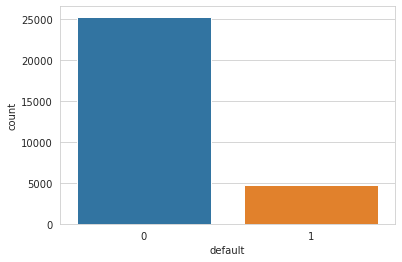

In [182]:
sns.countplot(y, data=df1)

# 2. Decision Tree

In [183]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_input, train_target)
print("no-prune training score: ", dt.score(train_input, train_target))
print("no-prune testing score: ",dt.score(test_input, test_target))

no-prune training score:  0.9935416666666667
no-prune testing score:  0.8768333333333334


In [184]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(train_input, train_target)
print("prune training score: ", dt.score(train_input, train_target))
print("prune testing score: ",dt.score(test_input, test_target))

prune training score:  0.9135
prune testing score:  0.9133333333333333


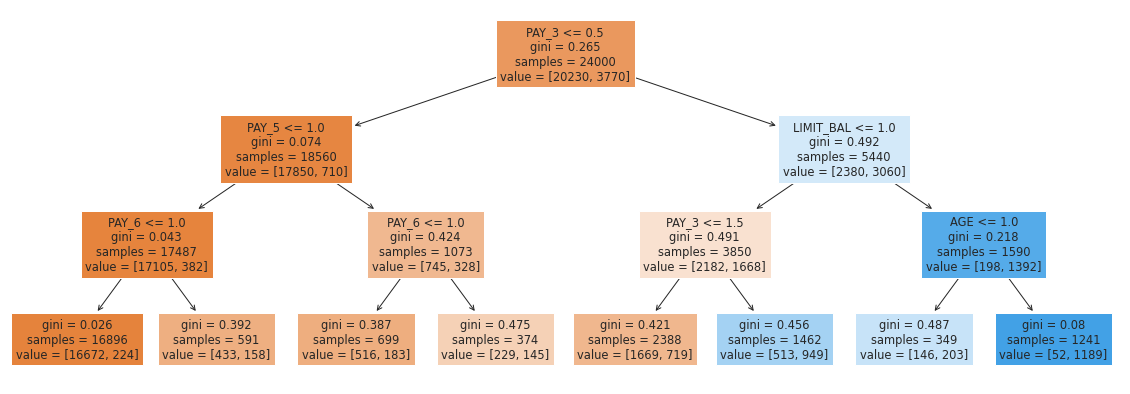

In [185]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
plt.figure(figsize=(20,7))
plot_tree(dt, filled=True, feature_names=['SEX', 'EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','LIMIT_BAL','AGE'])
plt.show()

In [186]:
print(dt.feature_importances_)

[0.         0.         0.         0.         0.         0.76875166
 0.         0.04945652 0.02472984 0.1336239  0.02343808]


In [187]:
# Normalize all features
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,stratify=target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train, random_state=42)

In [188]:
X_mean = X_train.mean()
X_std = X_train.std()

normalize = lambda raw: (raw - X_mean) / X_std
denormalize = lambda raw: raw * X_std + X_mean
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [189]:
# k folf (5) cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.9108333333333334


In [190]:
# 10 fold cross validation
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.9105000000000001


In [191]:
from sklearn.metrics import log_loss, auc, roc_auc_score
from sklearn import tree
depth = 40
tree_auc_trn, tree_auc_tst = np.zeros(depth), np.zeros(depth)
for i in range(1,depth):
    clf1 = tree.DecisionTreeClassifier(max_depth=i, criterion='gini')
    clf1 = clf1.fit(X_train, y_train)
    tree_auc_trn[i] = roc_auc_score(y_train, clf1.predict_proba(X_train)[:,1])
    tree_auc_tst[i] = roc_auc_score(y_test, clf1.predict_proba(X_test)[:,1])

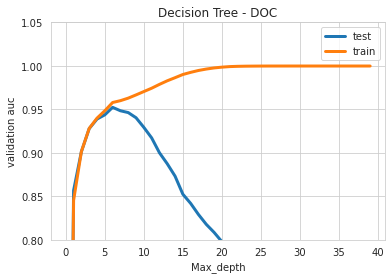

<Figure size 864x864 with 0 Axes>

In [192]:
plt.plot(tree_auc_tst, linewidth=3, label = "test")
plt.plot(tree_auc_trn, linewidth=3, label = "train")
plt.legend()
plt.ylim(0.8, 1.05)
plt.xlabel("Max_depth")
plt.title('Decision Tree - DOC')
plt.ylabel("validation auc")
plt.figure(figsize=(12,12))
plt.show()

# 3. Neural Networks

In [193]:
# Normalize all features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,stratify=target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train, random_state=42)

In [194]:
X_mean = X_train.mean()
X_std = X_train.std()

normalize = lambda raw: (raw - X_mean) / X_std
denormalize = lambda raw: raw * X_std + X_mean
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [195]:
result = {
    'Decision_Tree': {}, 
    'Neural_Network': {},
    'Boosting': {},
    'SVM': {},
    'k-NN': {}
}

In [196]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hidden_layer_sizes =  3 , activation =  relu
F1 Score:  0.7716576250753466
Training Accuracy:  0.8433333333333334
Testing Accuracy:  0.8433333333333334
Confusion Matrix
[[5060    0]
 [ 940    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      5060
           1       0.00      0.00      0.00       940

    accuracy                           0.84      6000
   macro avg       0.42      0.50      0.46      6000
weighted avg       0.71      0.84      0.77      6000

Cross Validation Score
[0.77165763 0.77165763 0.77165763 0.77165763 0.77165763]


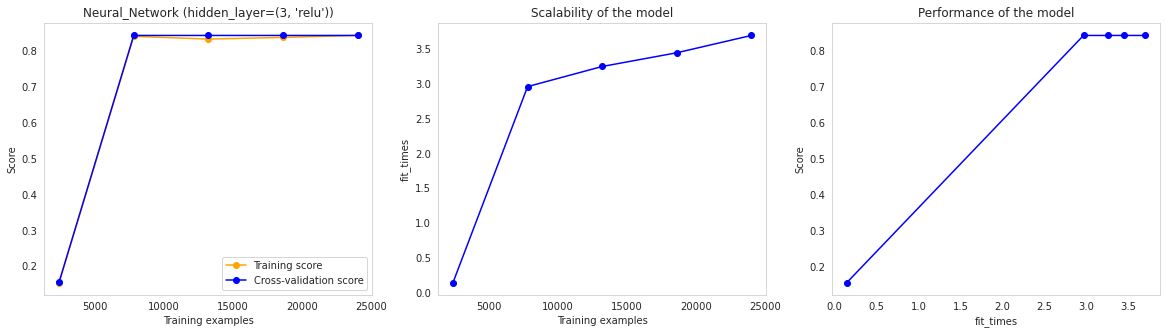

--------------------------------------------------
hidden_layer_sizes =  3 , activation =  tanh
F1 Score:  0.7716576250753466
Training Accuracy:  0.8433333333333334
Testing Accuracy:  0.8433333333333334
Confusion Matrix
[[5060    0]
 [ 940    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      5060
           1       0.00      0.00      0.00       940

    accuracy                           0.84      6000
   macro avg       0.42      0.50      0.46      6000
weighted avg       0.71      0.84      0.77      6000

Cross Validation Score
[0.77165763 0.77165763 0.77165763 0.77165763 0.77165763]


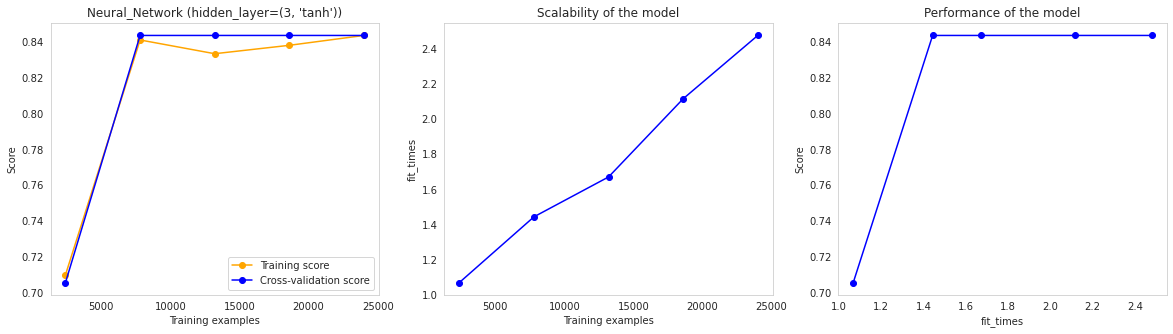

--------------------------------------------------
hidden_layer_sizes =  5 , activation =  relu
F1 Score:  0.7716576250753466
Training Accuracy:  0.8433333333333334
Testing Accuracy:  0.8433333333333334
Confusion Matrix
[[5060    0]
 [ 940    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      5060
           1       0.00      0.00      0.00       940

    accuracy                           0.84      6000
   macro avg       0.42      0.50      0.46      6000
weighted avg       0.71      0.84      0.77      6000

Cross Validation Score
[0.77165763 0.77165763 0.77165763 0.77165763 0.77165763]


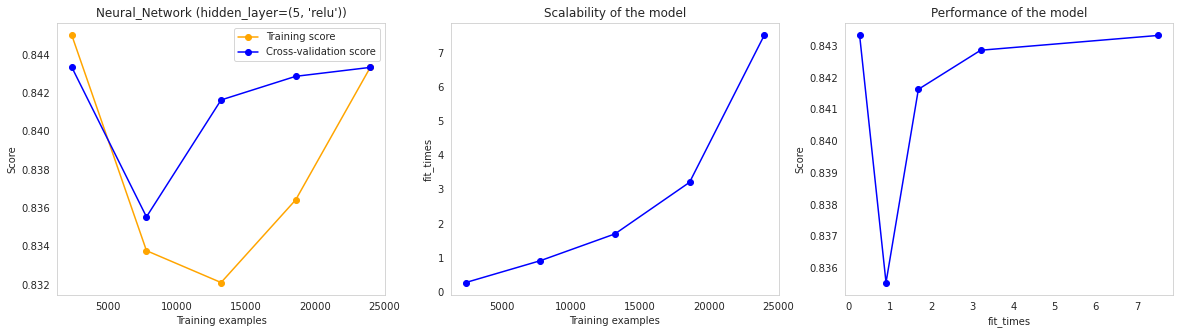

--------------------------------------------------
hidden_layer_sizes =  (3, 3) , activation =  relu
F1 Score:  0.7716576250753466
Training Accuracy:  0.8433333333333334
Testing Accuracy:  0.8433333333333334
Confusion Matrix
[[5060    0]
 [ 940    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      5060
           1       0.00      0.00      0.00       940

    accuracy                           0.84      6000
   macro avg       0.42      0.50      0.46      6000
weighted avg       0.71      0.84      0.77      6000

Cross Validation Score
[0.77165763 0.77165763 0.77165763 0.77165763 0.77165763]


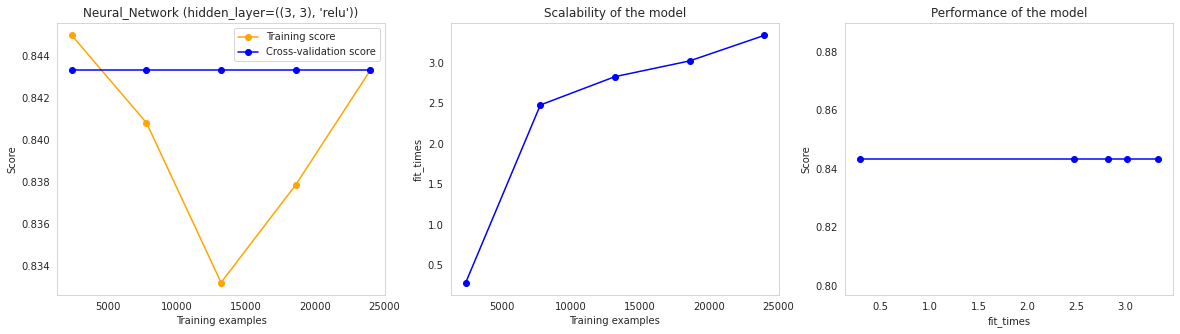

--------------------------------------------------
hidden_layer_sizes =  (5, 5, 5) , activation =  relu
F1 Score:  0.7716576250753466
Training Accuracy:  0.8433333333333334
Testing Accuracy:  0.8433333333333334
Confusion Matrix
[[5060    0]
 [ 940    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      5060
           1       0.00      0.00      0.00       940

    accuracy                           0.84      6000
   macro avg       0.42      0.50      0.46      6000
weighted avg       0.71      0.84      0.77      6000

Cross Validation Score
[0.77206038 0.77165763 0.77165763 0.77165763 0.77165763]


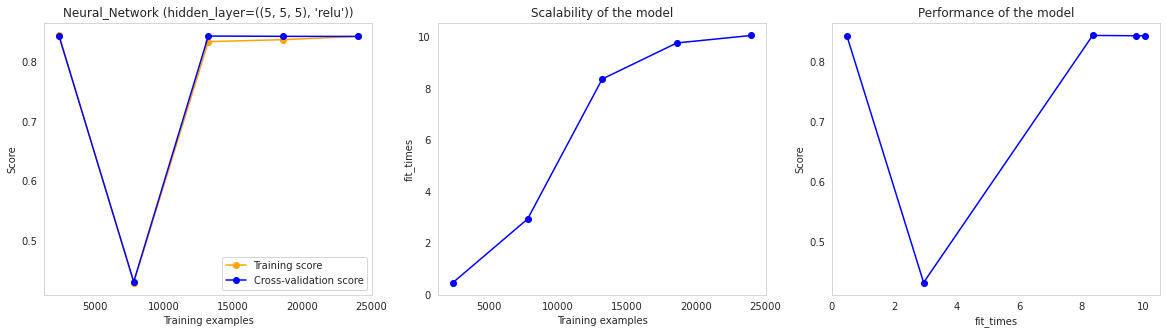

--------------------------------------------------
CPU times: user 2min 51s, sys: 960 ms, total: 2min 52s
Wall time: 3min 59s


In [197]:
%%time
task = "Neural_Network"
# Multi-layer Perceptron Classifier

f1 = []
train_acc = []
test_acc = []
params = [
    ((3), 'relu'),
    ((3), 'tanh'),
    ((5), 'relu'),   
    ((3, 3), 'relu'),
    ((5, 5, 5), 'relu'),
]
for k in params:
    print("hidden_layer_sizes = ", k[0], ", activation = ", k[1])
    clf = MLPClassifier(hidden_layer_sizes=k[0], activation = k[1],solver='adam',random_state=1)
    fit_tree = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    result[task][k] = {
        "f1" : f1_score(y_test,y_pred, average='weighted'),
        "training_acc": clf.score(X_train, y_train),
        "testing_acc": clf.score(X_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, data, target, cv=5, scoring='f1_weighted'),
    }
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    print("Cross Validation Score")
    print(result[task][k]["cross_validation_score"])
    
    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])
    
    # Learning Curve
    plot_learning_curve(clf, f"{task} (hidden_layer={k})", data, target, axes=None, cv=5, n_jobs=4)
    plt.show()

    
    print("--------------------------------------------------")

/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


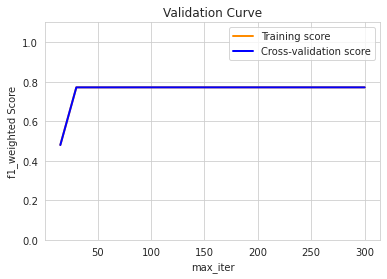

In [198]:
# Validation Curve
chosen_size = (3)
chosen_activation = 'relu'
max_iter_list = [15, 30, 60, 90, 150, 240, 300]
plot_validation_curve(MLPClassifier(hidden_layer_sizes=k[0],activation = chosen_activation,solver='adam',random_state=1), 
                      f"{task}: hidden_layer_sizes={chosen_size}, max_iter", data, target, "max_iter", max_iter_list, scoring="f1_weighted", axes=None, cv=5, n_jobs=4)

plt.show()


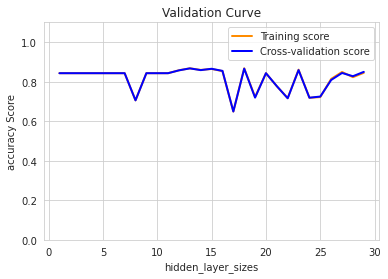

In [199]:
# Validation Curve
# chosen_size = (3)
chosen_activation = 'relu'
hidden_layer_sizes_list = [(x) for x in range(1,30)]
plot_validation_curve(MLPClassifier(hidden_layer_sizes=k[0], activation=chosen_activation,solver='adam',random_state=1), 
                      f"{task}: hidden_layer_sizes (1 hidden layer)", data, target, "hidden_layer_sizes", hidden_layer_sizes_list, scoring="accuracy", axes=None, cv=5, n_jobs=4)

plt.show()

# 4. Boosting

In [200]:
# 1. Random Forest

In [ ]:
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [225]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores_r = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores_r['train_score']), np.mean(scores_r['test_score']))

0.9945625000000001 0.8972083333333334


In [226]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.14987332 0.01736296 0.03705731 0.02096682 0.16788076 0.22223521
 0.12439257 0.08302054 0.05789038 0.05931131 0.06000882]


In [227]:
# OOB(out of bag) sample training
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.89425


Classifier =  AdaBoost
F1 Score:  0.8916344359560715
Training Accuracy:  0.8991145833333334
Testing Accuracy:  0.8993333333333333
Confusion Matrix
[[4910  160]
 [ 444  486]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5070
           1       0.75      0.52      0.62       930

    accuracy                           0.90      6000
   macro avg       0.83      0.75      0.78      6000
weighted avg       0.89      0.90      0.89      6000

Cross Validation Score
[0.88341379 0.89142233 0.89243018 0.88930794 0.88343665 0.89114777
 0.89938821 0.89364557 0.89499462 0.89197058]


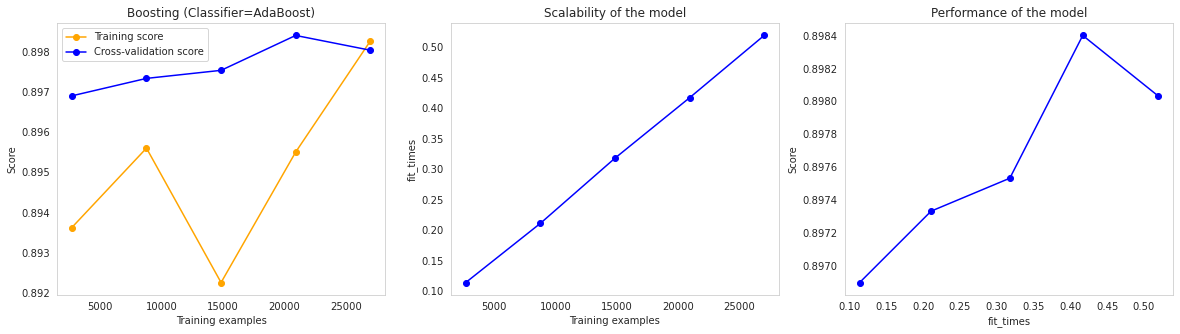

--------------------------------------------------
Classifier =  HistGradientBoosting
F1 Score:  0.9038351676175223
Training Accuracy:  0.9254166666666667
Testing Accuracy:  0.9076666666666666
Confusion Matrix
[[4877  193]
 [ 361  569]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5070
           1       0.75      0.61      0.67       930

    accuracy                           0.91      6000
   macro avg       0.84      0.79      0.81      6000
weighted avg       0.90      0.91      0.90      6000

Cross Validation Score
[0.90055816 0.89434088 0.90364635 0.89704513 0.90631992 0.91004784
 0.91889017 0.91820179 0.9126251  0.90551495]


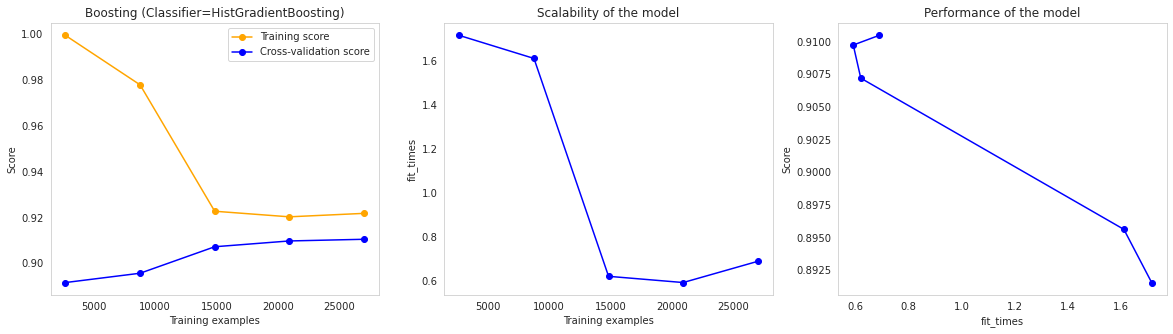

--------------------------------------------------
Classifier =  GradientBoosting
F1 Score:  0.9003972827583708
Training Accuracy:  0.9066666666666666
Testing Accuracy:  0.9056666666666666
Confusion Matrix
[[4896  174]
 [ 392  538]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5070
           1       0.76      0.58      0.66       930

    accuracy                           0.91      6000
   macro avg       0.84      0.77      0.80      6000
weighted avg       0.90      0.91      0.90      6000

Cross Validation Score
[0.8923898  0.89445063 0.89752192 0.89431672 0.89695776 0.89972403
 0.91214537 0.90611912 0.90611252 0.90341528]


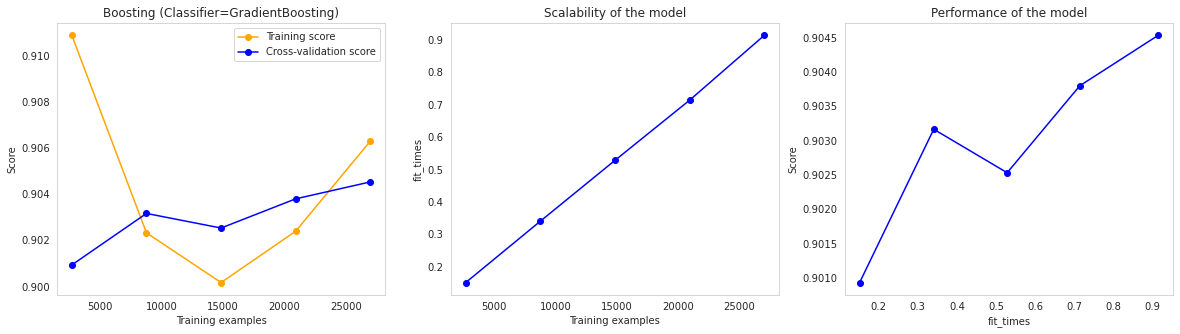

--------------------------------------------------


TypeError: __init__() got an unexpected keyword argument 'subsample'

In [ ]:
%%time
task = "Boosting"
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)

base_estim = DecisionTreeClassifier(max_depth=1, max_features=0.06)

f1 = []
train_acc = []
test_acc = []
params = ["AdaBoost", "GradientBoosting", "HistGradientBoosting"]

for k, clf in [
    ("AdaBoost", AdaBoostClassifier(base_estimator=base_estim,
                        # n_estimators=100,
                        learning_rate=0.5,
                        random_state=42)),
    ("HistGradientBoosting", HistGradientBoostingClassifier(max_iter=300,
                                      validation_fraction=0.1,
                                      n_iter_no_change=15,
                                      verbose=0,
                                      random_state=42)),
    ("GradientBoosting", GradientBoostingClassifier( # n_estimators=100,
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=42)),
]:
    print("Classifier = ", k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    result[task][k] = {
        "f1" : f1_score(y_test,y_pred, average='weighted'),
        "training_acc": clf.score(X_train, y_train),
        "testing_acc": clf.score(X_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, data, target, cv=10, scoring='f1_weighted'),
    }
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    print("Cross Validation Score")
    print(result[task][k]["cross_validation_score"])
    
    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])

    plot_learning_curve(clf, f"{task} (Classifier={k})", data, target, axes=None, cv=10, n_jobs=4)
    plt.show()
    print("--------------------------------------------------")

    
# Validation Curve
n_estimator_list = [5, 10 , 20, 50, 100, 200, 300, 500, 1000, 1500, 2000]
plot_validation_curve(AdaBoostClassifier(
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=42), f"{task}: GradientBoosting - n_estimators", data, target, "n_estimators", n_estimator_list, scoring="f1_weighted", axes=None, cv=10, n_jobs=4)
plt.show()

# 5. KNN

In [205]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

In [206]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [207]:
knn.score(X_train, y_train)

0.90390625

In [208]:
knn.score(X_val, y_val)

0.8908333333333334

In [209]:
best_val = 0
best_n = 0
best_weights = ""
best_metric = ""
for n in range(1,20):
    for weights in ["uniform", "distance"]:
        for metric in ["euclidean", "manhattan", "minkowski"]:
            knn = KNeighborsClassifier(n_neighbors=n, weights=weights, metric=metric)
            knn.fit(X_train,y_train)
            val_score = knn.score(X_val, y_val)
            if val_score > best_val:
                best_val = val_score
                best_n = n
                best_weights = weights
                best_metric = metric
print("Best validation score: ", best_val)
print("Best n: ", best_n)
print("Best weights method: ", best_weights)
print("Best distance metric: ", best_metric)

Best validation score:  0.8935416666666667
Best n:  5
Best weights method:  uniform
Best distance metric:  euclidean


In [210]:
best_n = 5
best_weights = "uniform"
best_metric = "euclidean"
knn = KNeighborsClassifier(n_neighbors=best_n, weights=best_weights, metric=best_metric)
knn.fit(X_train,y_train)
print("Training score: ", knn.score(X_train, y_train))
print("Test score: ", knn.score(X_test, y_test))

Training score:  0.9180729166666667
Test score:  0.8941666666666667


In [211]:
error_rate = []
for n in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=n, weights="uniform", metric="euclidean")
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_val)
    error_rate.append(np.mean(pred_i != y_val))
    

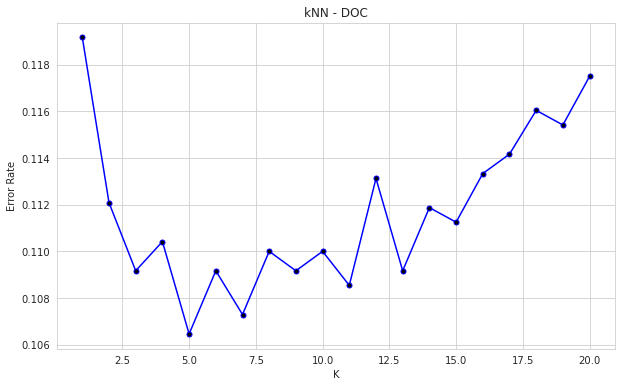

In [212]:
plt.figure(figsize=(10,6))
plt.plot(range(1,21),error_rate,color='blue', marker='o',
         markerfacecolor='black', markersize=5)
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.title('kNN - DOC')
plt.show()

In [213]:
kn = range(1,21,5)
kauc_trn, kauc_tst = np.zeros(len(kn)), np.zeros(len(kn))
for i, k in zip(range(0, len(kn)), kn):
    clf1 = KNeighborsClassifier(n_neighbors=k, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, p=2, weights='uniform')
    clf1 = clf1.fit(X_train, y_train)
    pred_tst = clf1.predict_proba(X_test)[:,1]
    pred_trn = clf1.predict_proba(X_train)[:,1]
    kauc_tst[i] = roc_auc_score(y_test, pred_tst)
    kauc_trn[i] = roc_auc_score(y_train, pred_trn)

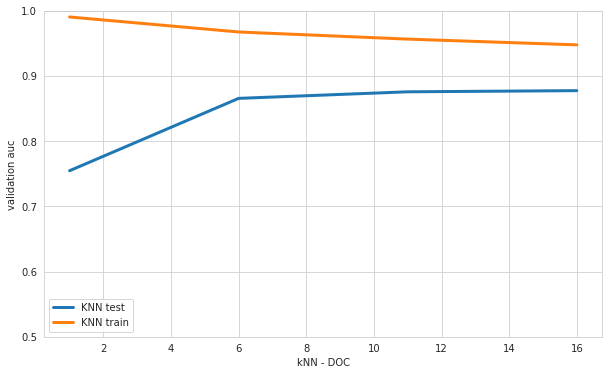

In [214]:
plt.figure(figsize=(10,6))
plt.plot(kn, kauc_tst, linewidth=3, label = "KNN test")
plt.plot(kn, kauc_trn, linewidth=3, label = "KNN train")
#pyplot.grid()
plt.legend()
plt.ylim(0.5, 1.0)
plt.xlabel("kNN - DOC")
plt.ylabel("validation auc")
plt.show()

# 6. SVM 

kernel =  poly
F1 Score:  0.774010840108401
Training Accuracy:  0.84203125
Testing Accuracy:  0.845
Confusion Matrix
[[5070    0]
 [ 930    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      5070
           1       0.00      0.00      0.00       930

    accuracy                           0.84      6000
   macro avg       0.42      0.50      0.46      6000
weighted avg       0.71      0.84      0.77      6000

Cross Validation Score
[0.77165763 0.77165763 0.77165763 0.77165763 0.77165763]


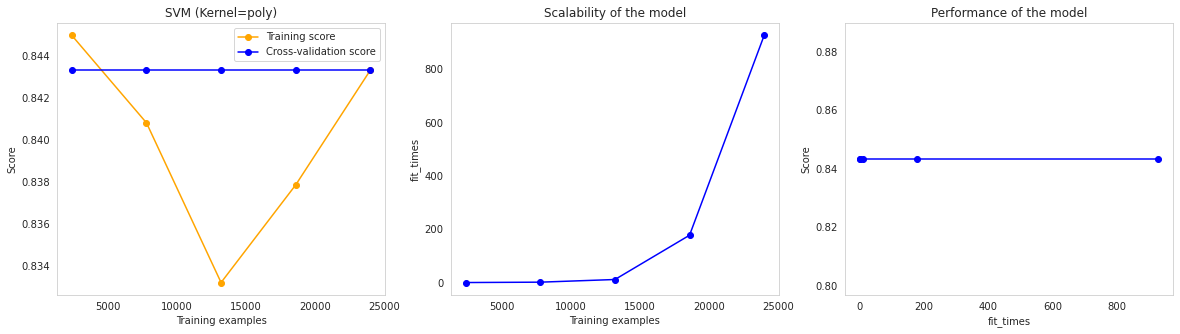

--------------------------------------------------
CPU times: user 1h 19min 16s, sys: 655 ms, total: 1h 19min 17s
Wall time: 1h 47min 34s


In [215]:
%%time
task = "SVM"

for k in ['poly']:
    print("kernel = ", k)
    clf = svm.SVC(decision_function_shape='ovo', kernel=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    result[task][k] = {
        "f1" : f1_score(y_test,y_pred, average='weighted'),
        "training_acc": clf.score(X_train, y_train),
        "testing_acc": clf.score(X_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, data, target, cv=5, scoring='f1_weighted'),
    }
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    print("Cross Validation Score")
    print(result[task][k]["cross_validation_score"])
    
    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])

    plot_learning_curve(clf, f"{task} (Kernel={k})", data, target, axes=None, cv=5, n_jobs=4)

    plt.show()
    print("--------------------------------------------------")

kernel =  rbf
F1 Score:  0.774010840108401
Training Accuracy:  0.84203125
Testing Accuracy:  0.845
Confusion Matrix
[[5070    0]
 [ 930    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      5070
           1       0.00      0.00      0.00       930

    accuracy                           0.84      6000
   macro avg       0.42      0.50      0.46      6000
weighted avg       0.71      0.84      0.77      6000

Cross Validation Score
[0.77165763 0.77165763 0.77165763 0.77165763 0.77165763]


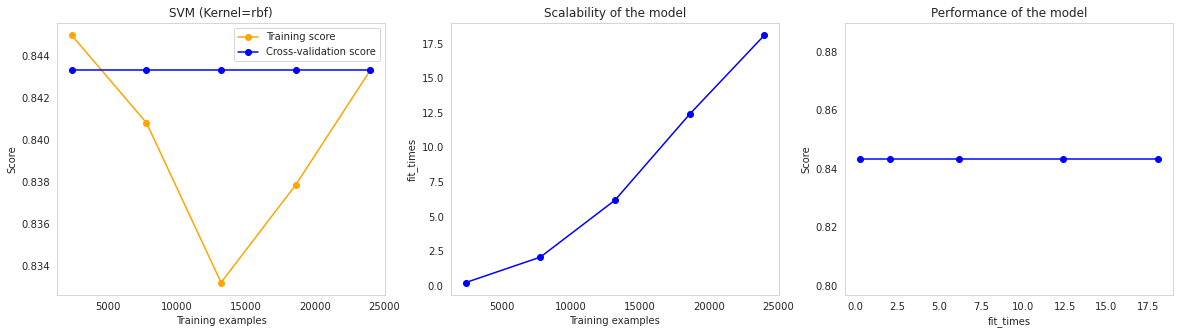

--------------------------------------------------
CPU times: user 2min 19s, sys: 672 ms, total: 2min 19s
Wall time: 4min 25s


In [ ]:
%%time
task = "SVM"

for k in ['rbf']:
    print("kernel = ", k)
    clf = svm.SVC(decision_function_shape='ovo', kernel=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    result[task][k] = {
        "f1" : f1_score(y_test,y_pred, average='weighted'),
        "training_acc": clf.score(X_train, y_train),
        "testing_acc": clf.score(X_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, data, target, cv=5, scoring='f1_weighted'),
    }
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    print("Cross Validation Score")
    print(result[task][k]["cross_validation_score"])
    
    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])

    plot_learning_curve(clf, f"{task} (Kernel={k})", data, target, axes=None, cv=5, n_jobs=4)

    plt.show()
    print("--------------------------------------------------")

In [ ]:
%%time

# Grid Search
task = "SVM"
k = "rbf_gridsearch"
# Parameter Grid
param_grid = {'C': [0.1, 1], 'gamma': [1, 0.1]}

# Make grid search classifier
clf_grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, verbose=1, cv=10)

# Train the classifier
clf_grid.fit(X_train, y_train)

y_pred = clf_grid.predict(X_test)
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

result[task][k] = {
        "f1" : f1_score(y_test,y_pred, average='weighted'),
        "training_acc": clf_grid.score(X_train, y_train),
        "testing_acc": clf_grid.score(X_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf_grid, data, target, cv=10, scoring='f1_weighted'),
        "best_parameters": clf_grid.best_params_,
        "best_estimators": clf_grid.best_estimator_
    }

print("F1 Score: ", result[task][k]["f1"])
print("Training Accuracy: ", result[task][k]["training_acc"])
print("Testing Accuracy: ", result[task][k]["testing_acc"])
print("Confusion Matrix")
print(result[task][k]["confusion_mat"])
print("Classification Report")
print(result[task][k]["classification_report"])
print("Cross Validation Score")
print(result[task][k]["cross_validation_score"])
print("Best Params : ", result[task][k]["best_parameters"])
    
# Add to lists
f1.append(result[task][k]["f1"])
train_acc.append(result[task][k]["training_acc"])
test_acc.append(result[task][k]["testing_acc"])

plot_learning_curve(clf_grid, f"{task} (Kernel={k})", data, target, axes=None, cv=2, n_jobs=4)

plt.show()

# Validation Curve
param_range = np.logspace(-3, 0, 4)
plot_validation_curve(svm.SVC(kernel='linear'), 
                      f"{task}: RBF - gamma, max_iter", data, target, "gamma", param_range, scoring="f1_weighted", axes=None, cv=2, n_jobs=4)
plt.show()

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters:
 {'C': 1, 'gamma': 0.1}
Best Estimators:
 SVC(C=1, gamma=0.1)
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [ ]:
# Validation Curve
param_range = np.logspace(-3, 0, 4)
plot_validation_curve(svm.SVC(kernel='rbf'), 
                      f"{task}: RBF - gamma, max_iter", data, target, "gamma", param_range, scoring="f1_weighted", axes=None, cv=2, n_jobs=4)
plt.show()